In [23]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
lines = [8498.02,8542.09,8662.14]
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

vispath = path + 'VIS_notell/'
sp = glob.glob(vispath+'*TAC.csv')

In [293]:
line_list = Table.read('line_positions.ecsv')

In [294]:
all_sp = line_list

In [295]:
len(line_list[line_list['Xs'] !=  -1.0])

24

In [296]:
line_list = line_list[line_list['Xs'] !=  -1.0]

In [297]:
sp_lines, xs = line_list['FILENAME'], line_list['Xs']

In [262]:
def get_shifted_lines(x, lines):
    #calculates the approximate positions of the shifted lines
    rest_lam = lines[0]*u.AA
    obs_lam = x*u.AA
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
    #print(dv)
    l2 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[1]*u.AA))
    l3 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[2]*u.AA))
    return np.array([x, l2.value, l3.value])

def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    smooth = 10
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne
    
    
def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error
#get_shifted_lines(xs[0], lines)

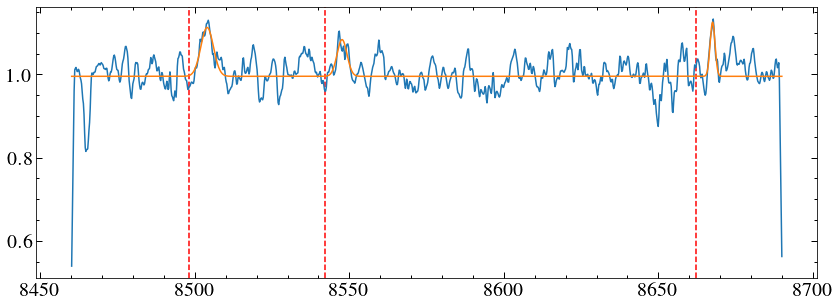

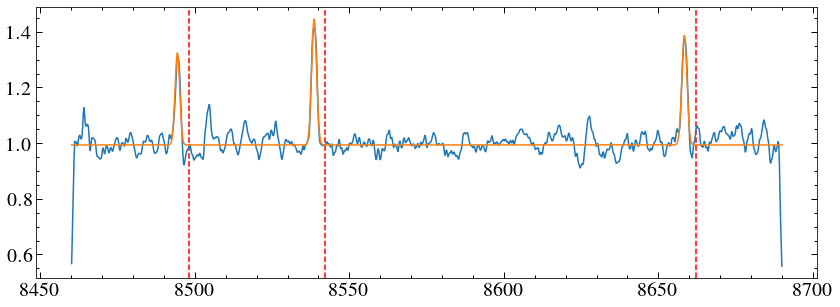

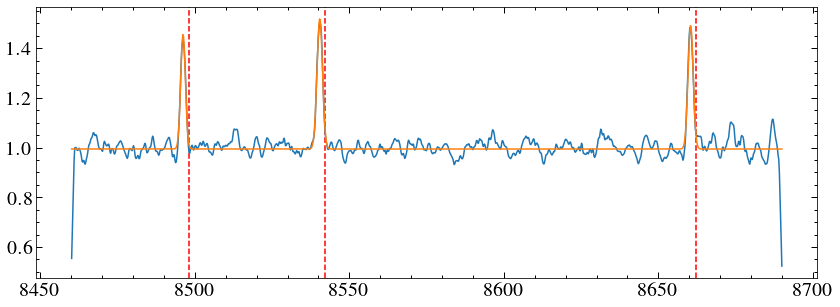

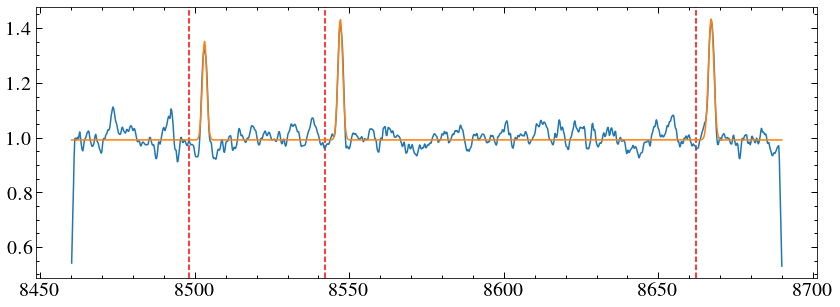

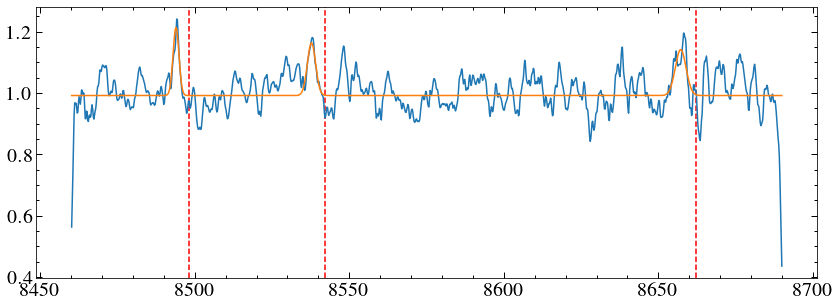

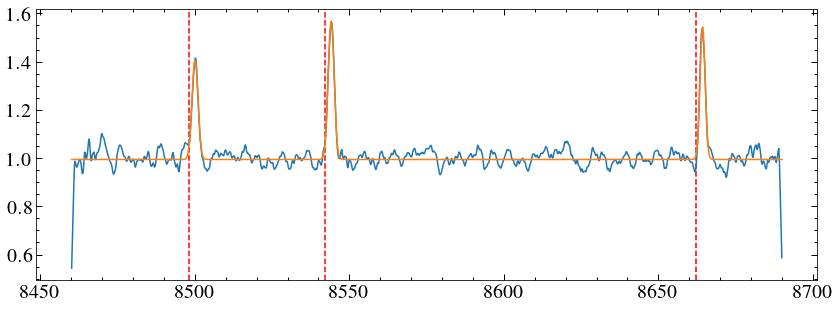

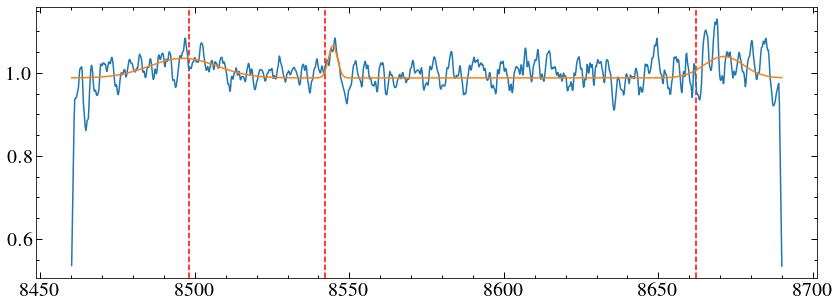

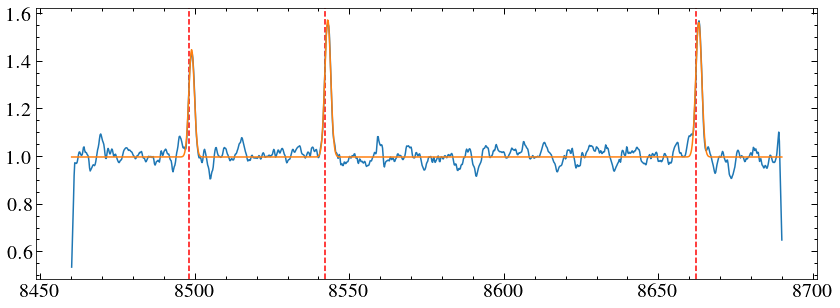

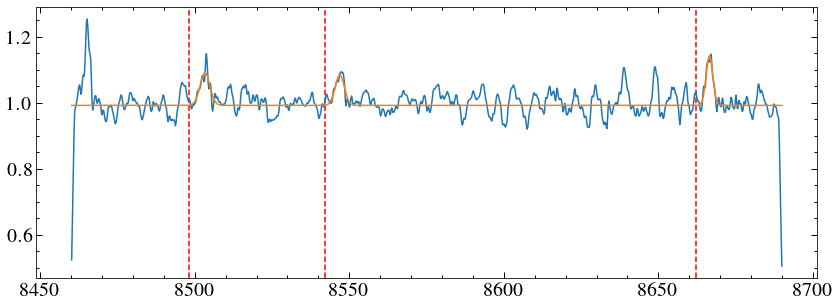

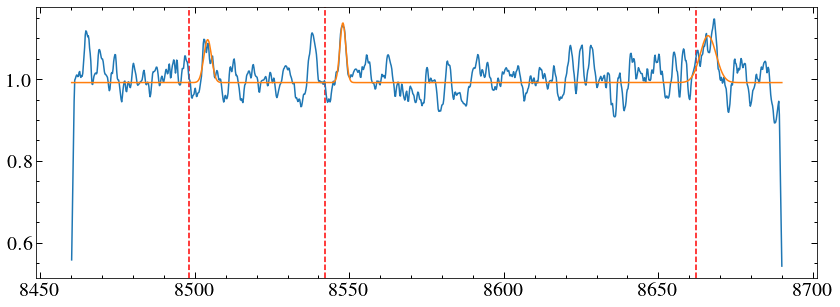

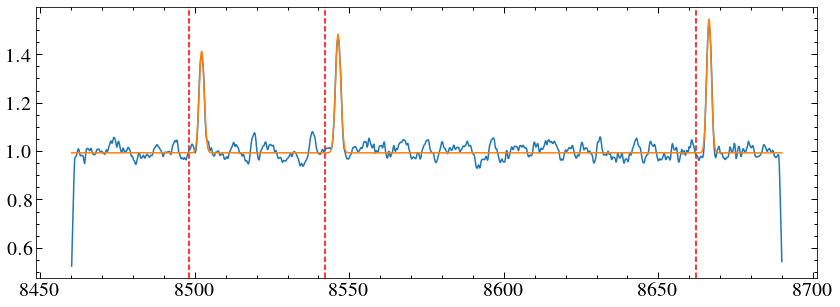

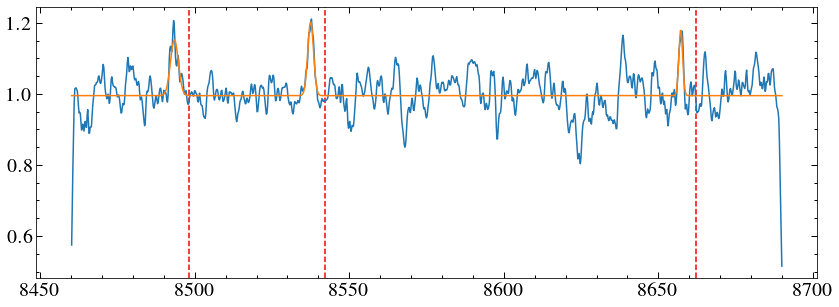

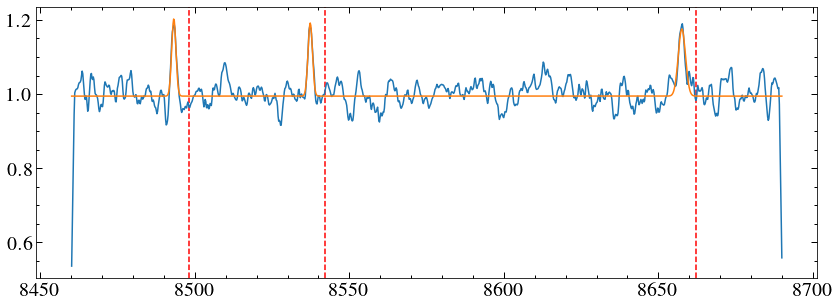

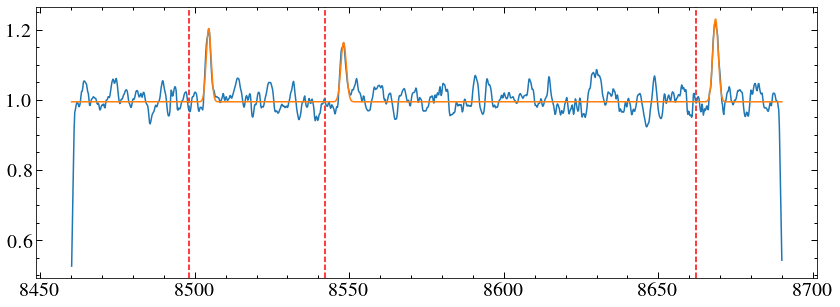

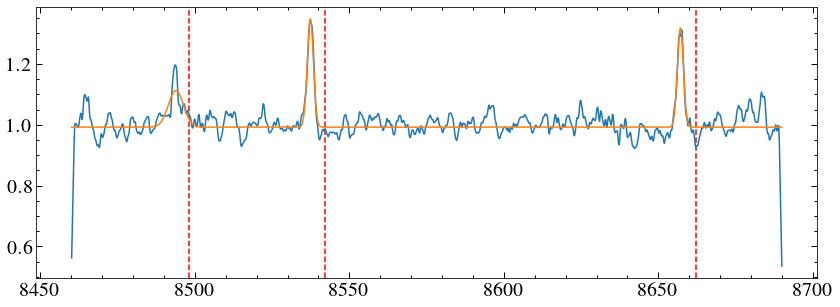

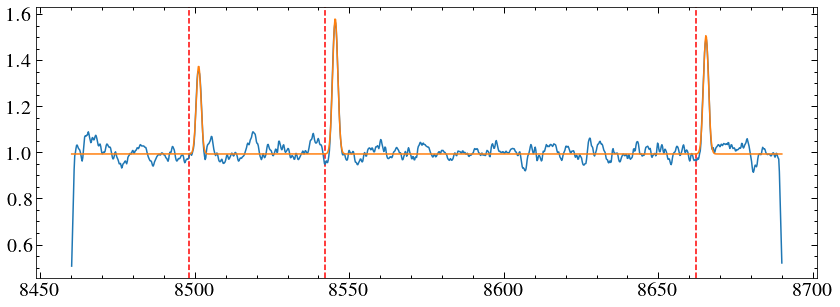

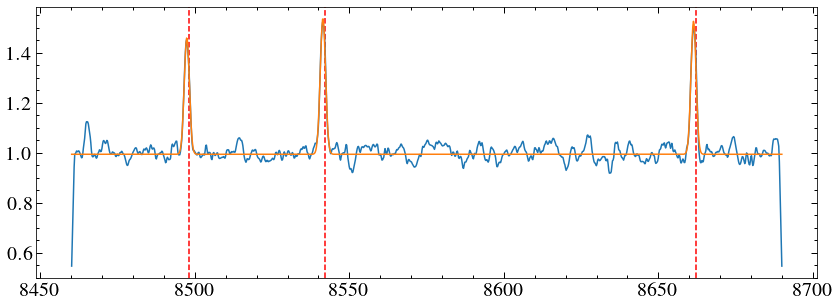

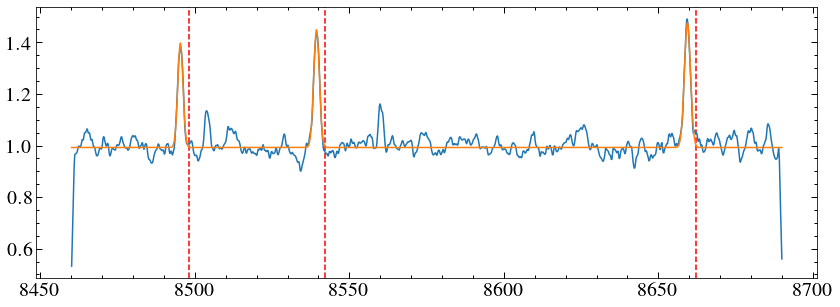

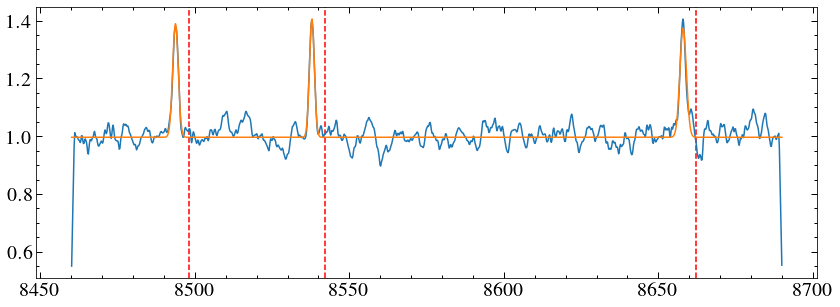

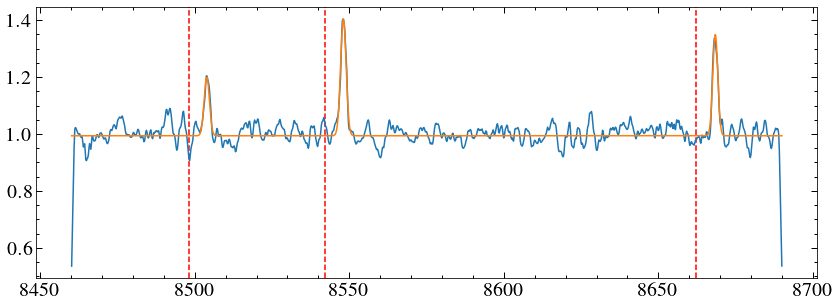

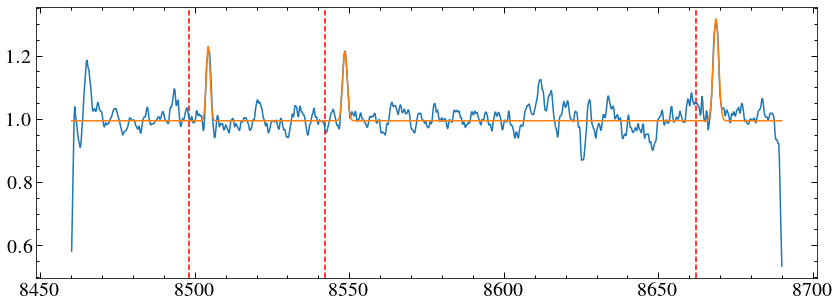

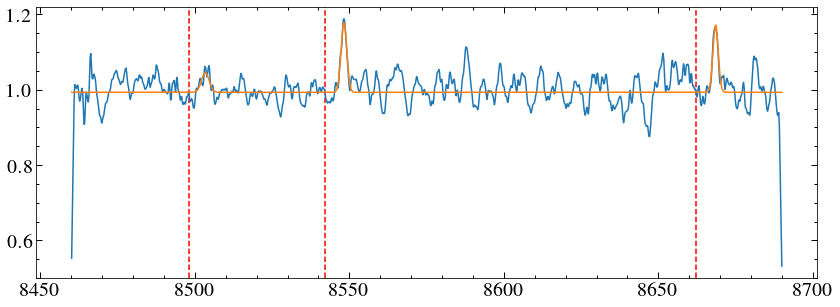

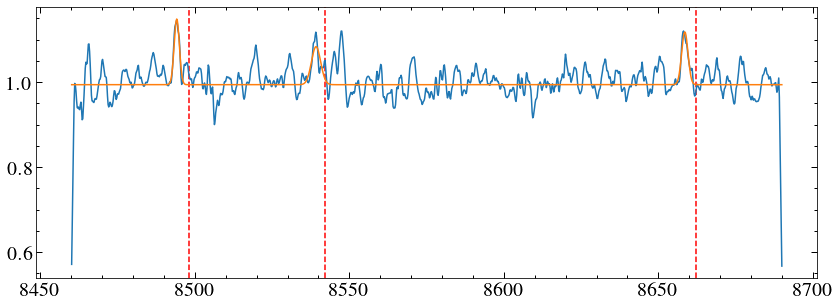

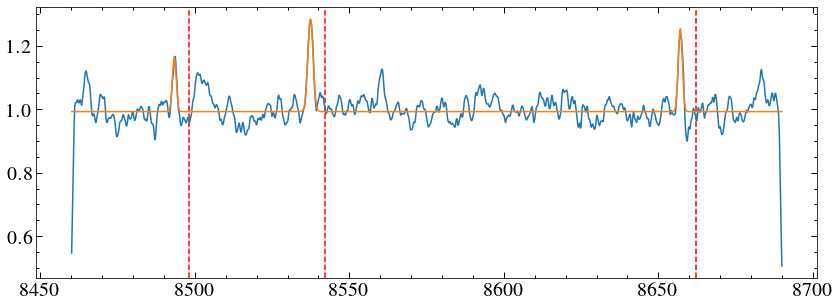

In [269]:
fitter = fitting.LevMarLSQFitter()
dvs = []
dves = []
dates = []
for s, x in zip(sp_lines, xs):
   # print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    dates.append(date)
    
    
    plt.figure() 
    for i in range(len(lines)):
        line = lines[i]
        guess = slines[i]
        if i == 0:
            gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
        else:
            gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
        plt.axvline(line, c='r', ls='--')
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=1000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    
    plt.plot(w, f)
    plt.plot(w, gg_fit(w))
    plt.show()
    obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
    obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]
    
    e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
    e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
    es = np.mean([e_up, e_down], axis=0)
    #print(len(es))
    dv, dve = dv_average(dv, es)
    dvs.append(dv)
    dves.append(dve)
    
    #dvs.append(np.mean(dv))
    #print(np.std(dv))
    
    

<ErrorbarContainer object of 3 artists>

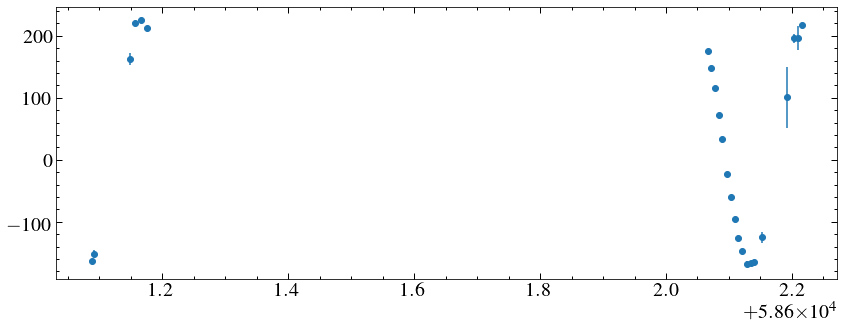

In [274]:
plt.errorbar(dates, dvs, yerr=dves, marker='o', ls='none')

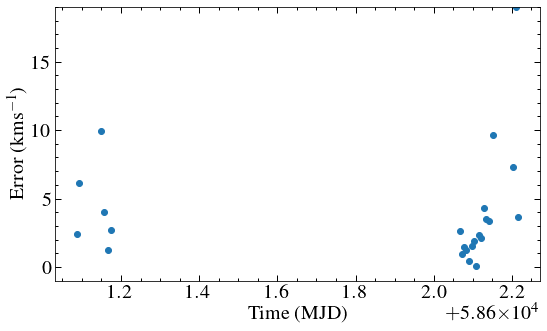

In [275]:
plt.figure(figsize=(8,5))
plt.errorbar(dates, dves, marker='o', ls='none')
plt.ylim(-1, 19)
plt.xlabel('Time (MJD)')
plt.ylabel('Error (kms$^{-1}$)')
plt.tight_layout()
plt.savefig('errortest.png')

In [276]:
from astropy.timeseries import LombScargle

In [277]:

dates = np.array(dates) + (150/86400)
args = np.argsort(dates)

In [278]:
t = dates[args]
dvs = np.array(dvs)[args]
dves= np.array(dves)[args]
t = (t-t[0])*24

<ErrorbarContainer object of 3 artists>

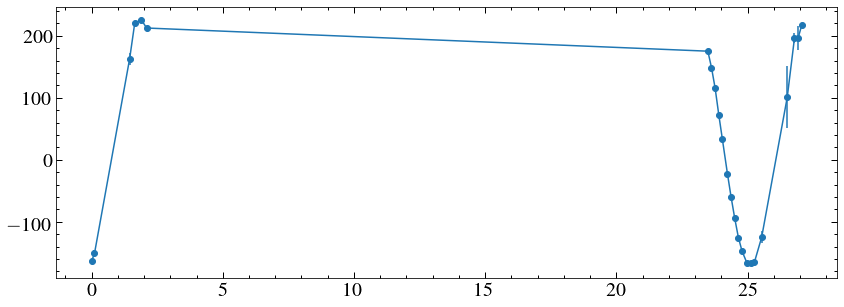

In [279]:
plt.errorbar(t, dvs, yerr=dves, marker='o')

4.219081272084805


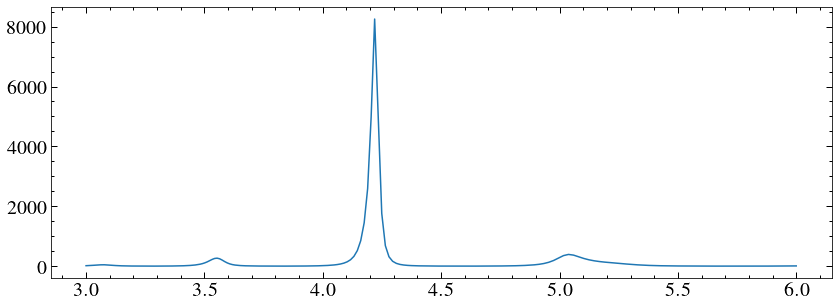

In [280]:
frequency = np.linspace(1/6, 1/3, 200)
power = LombScargle(t, dvs, dves, normalization='model').power(frequency)#.autopower(minimum_frequency =1/4.5, maximum_frequency = 1/3.8)#frequency)
plt.plot(1/frequency, power)
#plt.xlim(2,10)
period = 1/frequency[np.argmax(power)]
print(period)

<ErrorbarContainer object of 3 artists>

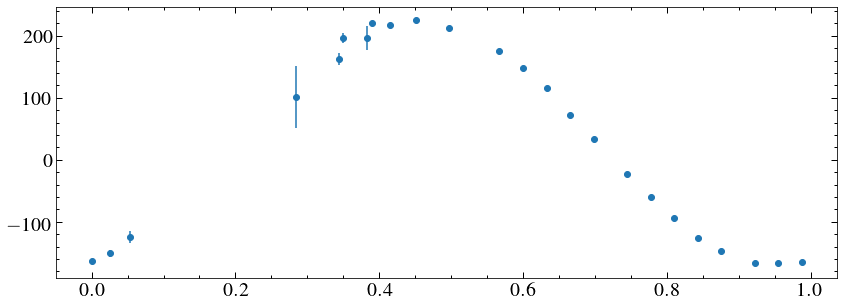

In [281]:
t_fold = (t/period) %1
plt.errorbar(t_fold, dvs, yerr=dves, marker='o', ls='none')

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 39417.2133428176
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Model: CompoundModel1598
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=27.)>

    [1]: <Sine1D(amplitude=190., frequency=0.23640662, phase=-2260.20259328)>
Parameters:
    amplitude_0 amplitude_1     frequency_1           phase_1      
    ----------- ----------- ------------------- -------------------
           27.0       190.0 0.23640661938534277 -2260.2025932837037
4.23


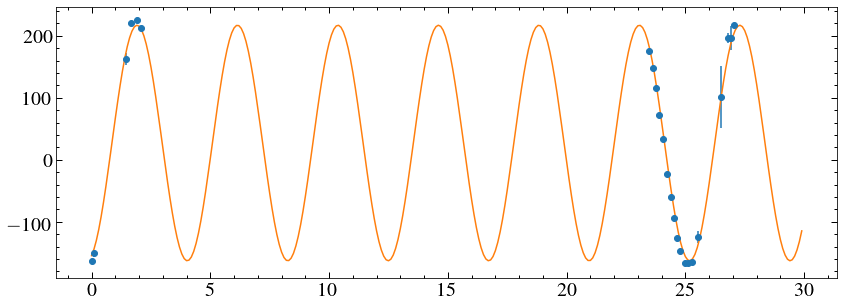

In [292]:
fitter = fitting.SLSQPLSQFitter()
sine_mod =  models.Const1D(27, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=190, frequency=1/4.23, phase = -2260.2025932837037,bounds=dict(amplitude=[170, 250], frequency=[1/4.5, 1/4.1]))
sine_fit = fitter(sine_mod, t, dvs, weights=1/dves, maxiter=100)
print(sine_fit)
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')
#phase_t = np.arange(0,1.01, 0.01 )
#plt.plot(phase_t, sine_fit(phase_t))
t_plot = np.arange(0, 30, 0.1)
plt.plot(t_plot, sine_fit(t_plot))
print(1/sine_fit[1].frequency)

In [150]:
print (max(dvs) - abs(min(dvs)))
print(max(dvs - ))

57.07217344284493
168.49639907776464


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 33.92217096533958
            Iterations: 19
            Function evaluations: 117
            Gradient evaluations: 19
Model: CompoundModel1593
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0       amplitude_1     frequency_1       phase_1      
    ----------------- ------------------ ----------- -------------------
    28.46834298446116 197.14527643788762         1.0 -2260.2025932837037


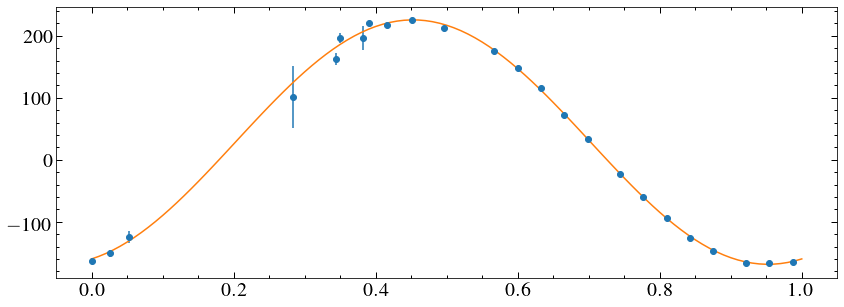

In [285]:
fitter = fitting.SLSQPLSQFitter()
#fitter = fitting.LevMarLSQFitter()

sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[100, 200]), fixed=dict(frequency=1))
sine_fit = fitter(sine_mod, t_fold, dvs, weights=1/dves, maxiter=100000)
print(sine_fit)
plt.errorbar(t_fold, dvs, yerr=dves, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
#t_plot = np.arange(0, 30, 0.1)
#plt.plot(t_plot, sine_fit(t_plot))

Model: CompoundModel1284
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0    amplitude_1 frequency_1       phase_1      
    ----------------- ----------- ----------- -------------------
    36.76844516954981       170.0         1.0 0.08410091508869247


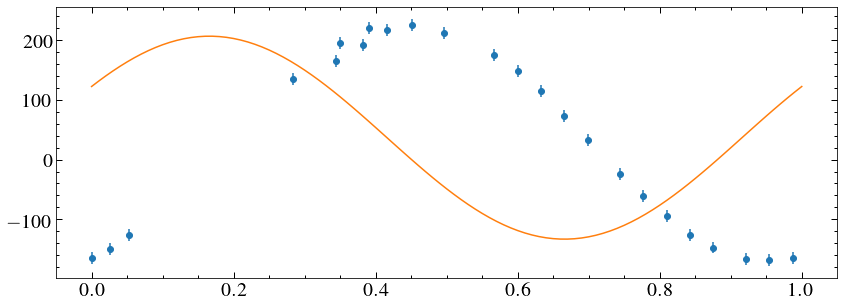

In [247]:
fitter = fitting.SLSQPLSQFitter()
fitter = fitting.LevMarLSQFitter()
errs = np.full(len(t_fold), 10)
sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[170, 250]), fixed=dict(frequency=1))
sine_fit = fitter(sine_mod, t_fold, dvs, errs, maxiter=10000)
print(sine_fit)
plt.errorbar(t_fold, dvs, yerr=errs, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
#t_plot = np.arange(0, 30, 0.1)
#plt.plot(t_plot, sine_fit(t_plot))

Can't deal with errors for some reason -fixed- weights = 1/e

Try the absorption lines?

Model: CompoundModel2228
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6566.64970136, stddev=0.5)>
Parameters:
        amplitude_0           mean_0      ...        stddev_4       
    ------------------- ----------------- ... ----------------------
    -0.1546492640133202 6564.360691076469 ... 1.1754943508222875e-38


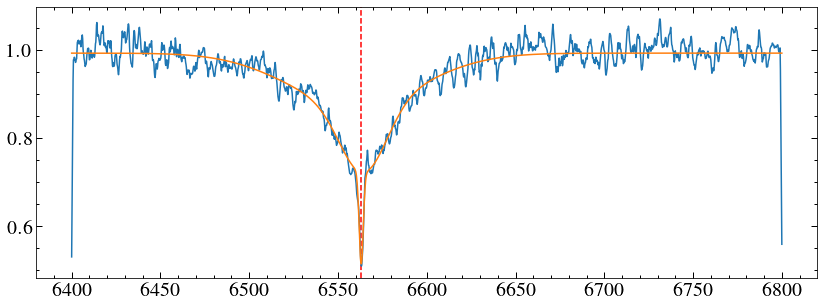

Model: CompoundModel2231
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
        amplitude_0            mean_0      ...      stddev_2         amplitude_3    
    -------------------- ----------------- ... ------------------ ------------------
    -0.14912398136316557 6564.743286675553 ... 24.826314782982855 0.9940899328729945


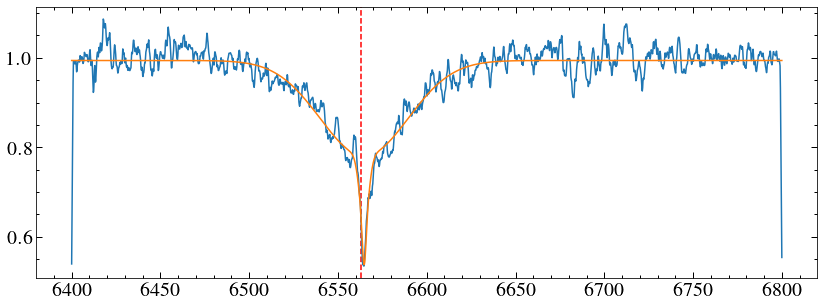

Model: CompoundModel2234
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
        amplitude_0           mean_0      ...      stddev_2        amplitude_3    
    -------------------- ---------------- ... ----------------- ------------------
    -0.11923088726246439 6564.66702439733 ... 31.27996675742863 0.9926216286810575


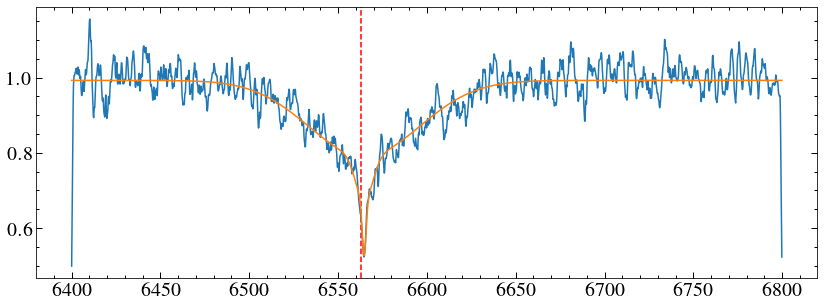

Model: CompoundModel2238
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6560.48917963, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...        stddev_4       
    -------------------- ----------------- ... ----------------------
    -0.17154527942301478 6565.960501234714 ... 1.1754943508222875e-38


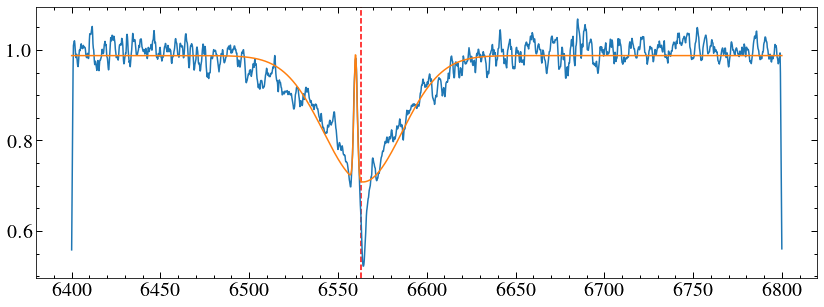

Model: CompoundModel2242
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6561.17501578, stddev=0.5)>
Parameters:
        amplitude_0           mean_0      ...        stddev_4       
    ------------------- ----------------- ... ----------------------
    -0.1044746209257081 6567.433991311482 ... 1.1754943508222875e-38


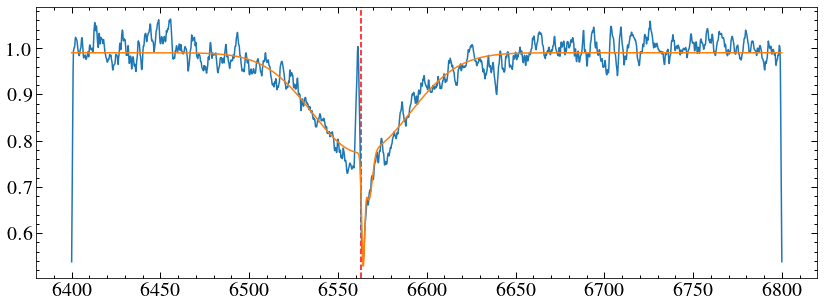

Model: CompoundModel2246
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6567.11483735, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...       mean_4           stddev_4     
    -------------------- ----------------- ... ----------------- ------------------
    -0.11519679619122916 6563.496961728626 ... 6566.625966723053 0.9905760817109172


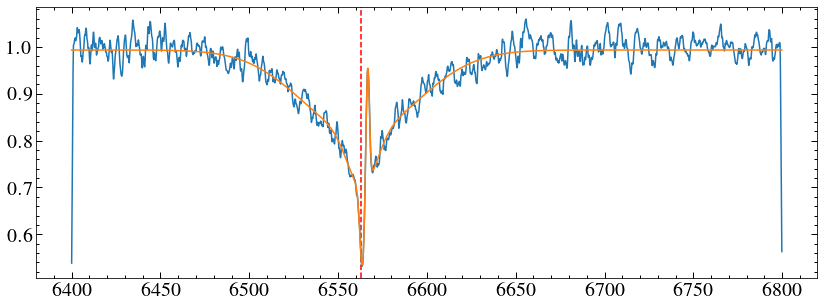

Model: CompoundModel2249
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
        amplitude_0           mean_0      ...      stddev_2         amplitude_3    
    ------------------- ----------------- ... ------------------ ------------------
    -0.1220709629556795 6563.262066624485 ... 29.471379265503153 0.9927611881133039


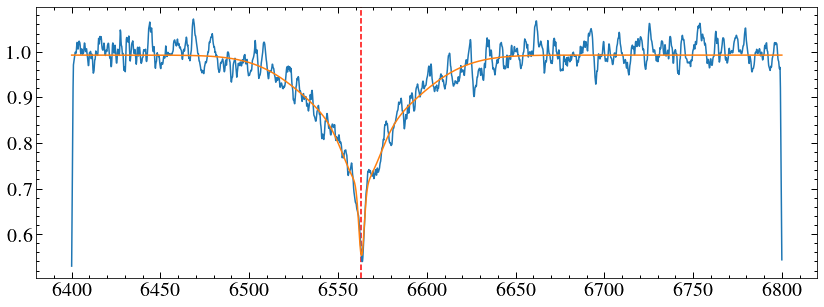

Model: CompoundModel2252
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
        amplitude_0           mean_0      ...      stddev_2         amplitude_3    
    -------------------- ---------------- ... ------------------ ------------------
    -0.09715839511228262 6563.03937681444 ... 27.703951215422183 0.9936708989381653


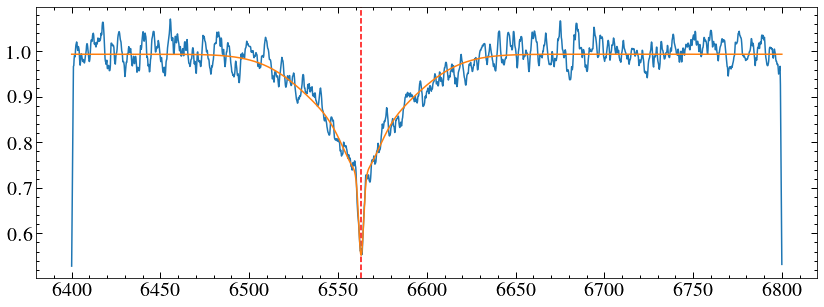

Model: CompoundModel2255
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
        amplitude_0           mean_0      ...      stddev_2        amplitude_3    
    ------------------- ----------------- ... ----------------- ------------------
    -0.1396202542273378 6564.058293598801 ... 32.47886420809672 0.9928488764232344


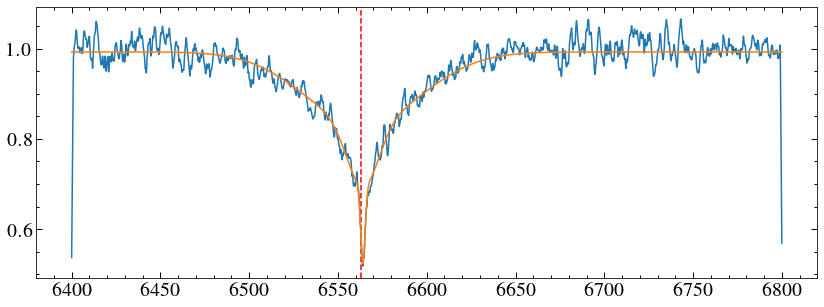

Model: CompoundModel2258
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
        amplitude_0            mean_0       ...      stddev_2        amplitude_3    
    -------------------- ------------------ ... ----------------- ------------------
    -0.12744977346706438 6563.6164011347755 ... 33.26452665897707 0.9906727166358396


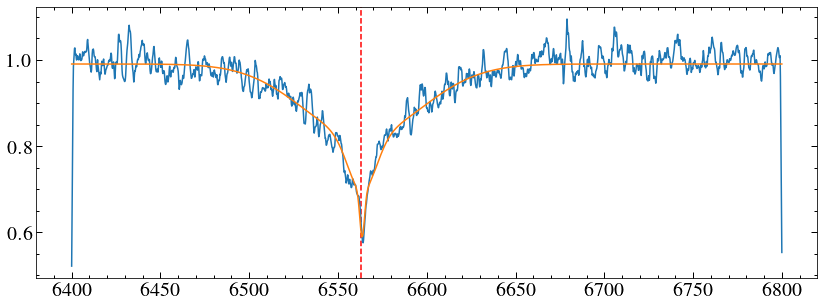

Model: CompoundModel2262
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6559.5853735, stddev=0.5)>
Parameters:
        amplitude_0           mean_0      ...       mean_4            stddev_4     
    ------------------- ----------------- ... ------------------ ------------------
    -0.1955602614802336 6562.904950912964 ... 6559.4292872497945 1.3098255531907517


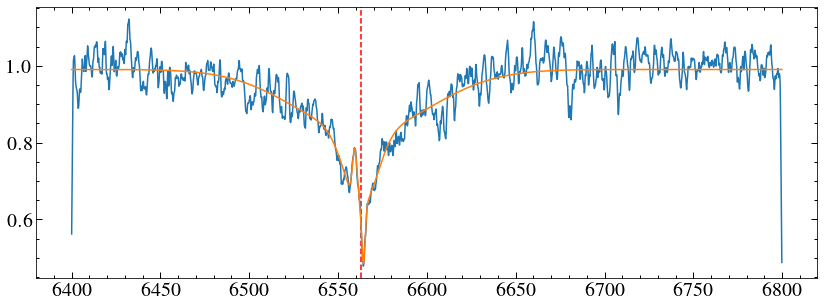

Model: CompoundModel2266
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6564.83008461, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...       mean_4           stddev_4     
    -------------------- ----------------- ... ----------------- ------------------
    -0.03486913529925056 6563.195687232853 ... 6563.826711471247 1.0283762961593972


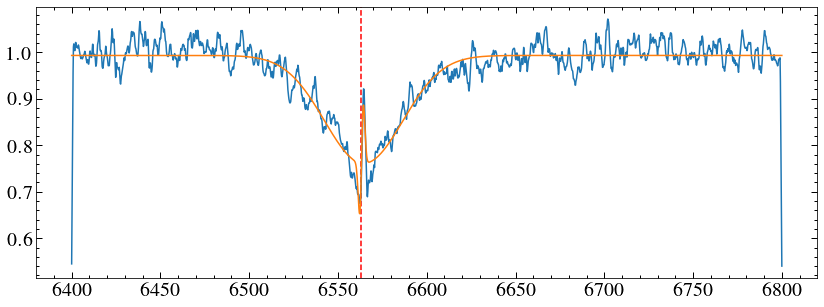

Model: CompoundModel2270
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6565.73684919, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...       mean_4           stddev_4     
    -------------------- ----------------- ... ----------------- ------------------
    -0.14428413567738754 6565.237116628626 ... 6563.431619035216 0.9894305545019065


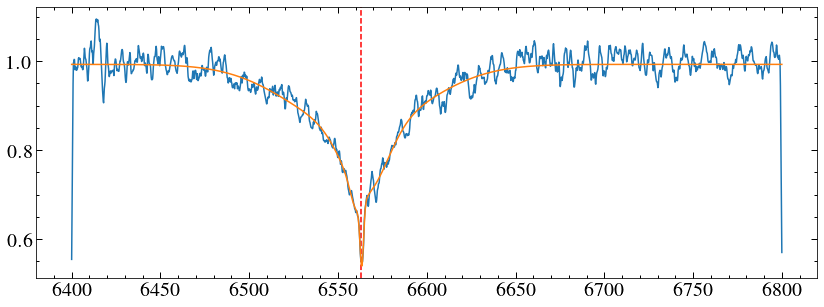

Model: CompoundModel2274
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6563.6878978, stddev=0.5)>
Parameters:
        amplitude_0           mean_0       ...       mean_4           stddev_4     
    ------------------- ------------------ ... ----------------- ------------------
    -0.1277910539968128 6563.5563065356455 ... 6562.944230880358 0.9643971965321327


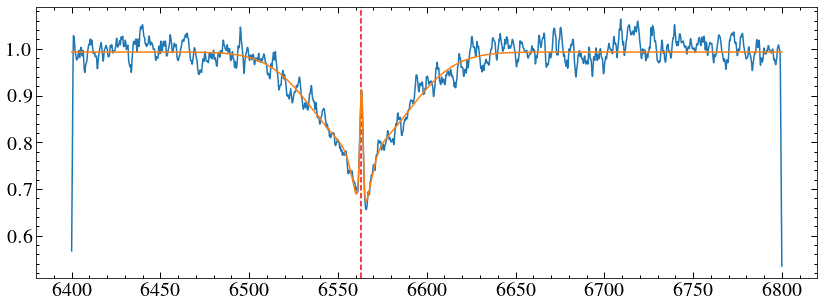

Model: CompoundModel2278
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6566.88933686, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...       mean_4           stddev_4    
    -------------------- ----------------- ... ----------------- -----------------
    -0.10976652486779401 6562.182901401314 ... 6566.549527302436 1.311318937523025


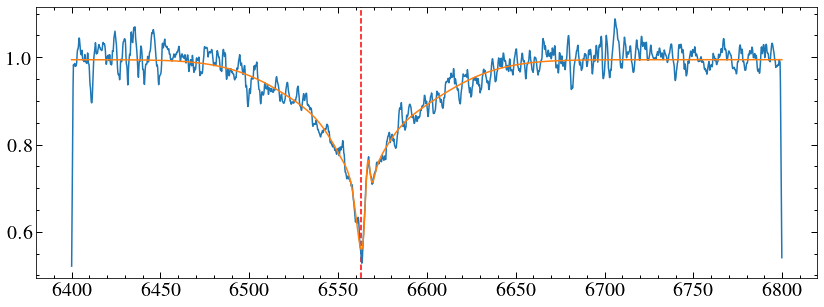

Model: CompoundModel2281
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
        amplitude_0            mean_0      ...      stddev_2         amplitude_3    
    -------------------- ----------------- ... ------------------ ------------------
    -0.13782147063234518 6564.005104026396 ... 26.484378329923054 0.9938051991694657


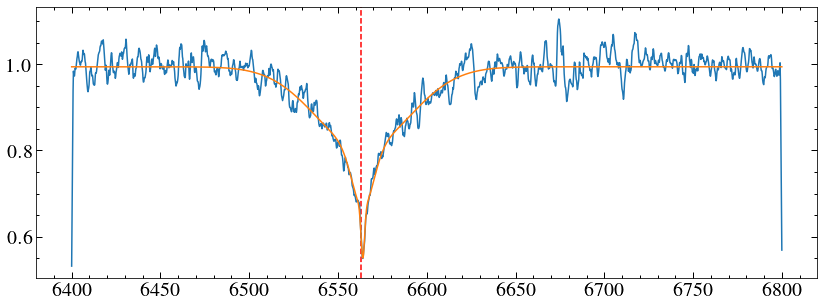

Model: CompoundModel2285
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6567.33450114, stddev=0.5)>
Parameters:
        amplitude_0          mean_0      ...       mean_4           stddev_4     
    ------------------- ---------------- ... ----------------- ------------------
    -0.1101607945436899 6565.43023424506 ... 6567.179157757244 0.8166836028520662


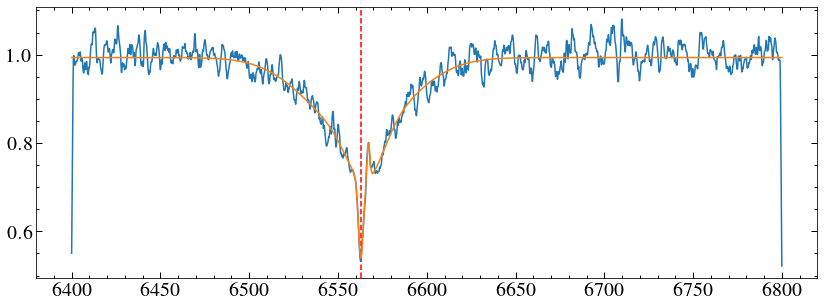

Model: CompoundModel2289
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6566.20101272, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...        stddev_4       
    -------------------- ----------------- ... ----------------------
    -0.24684337314785867 6562.515513054276 ... 1.1754943508222875e-38


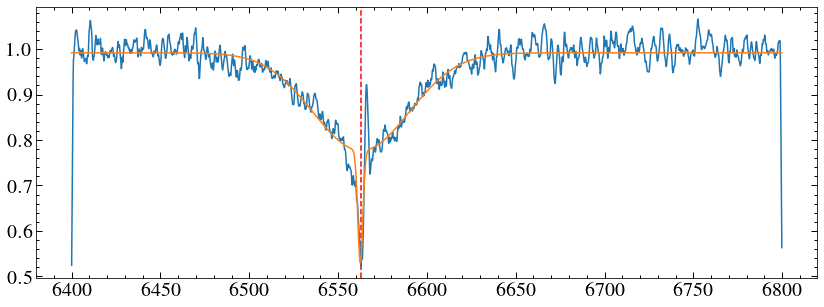

Model: CompoundModel2293
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6559.12895587, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...       mean_4           stddev_4     
    -------------------- ----------------- ... ----------------- ------------------
    -0.22049236067486788 6563.487727490672 ... 6559.050204338311 1.0067408918889809


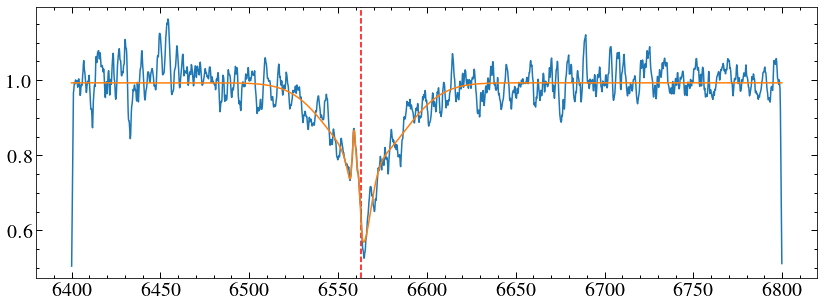

Model: CompoundModel2297
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6559.11739899, stddev=0.5)>
Parameters:
        amplitude_0           mean_0      ...       mean_4           stddev_4     
    -------------------- ---------------- ... ----------------- ------------------
    -0.19886132855514402 6564.15328681603 ... 6558.893217190036 0.6096982288941403


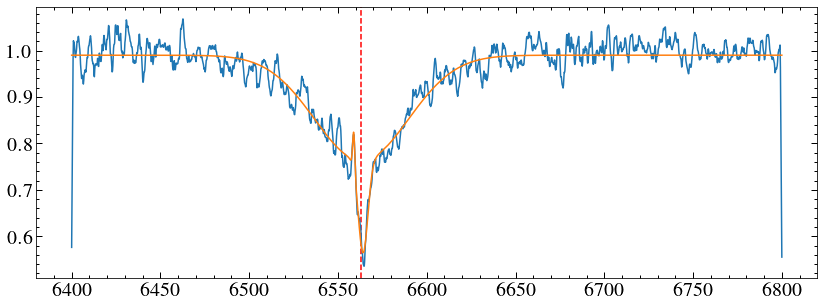

Model: CompoundModel2301
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6567.57392684, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...        stddev_4       
    -------------------- ----------------- ... ----------------------
    0.017473283273108473 6563.033633749118 ... 1.1754943508222875e-38


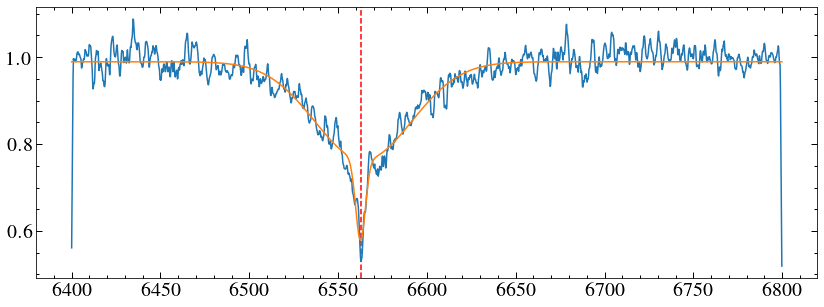

Model: CompoundModel2305
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6559.57484652, stddev=0.5)>
Parameters:
        amplitude_0           mean_0      ...       mean_4           stddev_4     
    ------------------- ----------------- ... ----------------- ------------------
    -0.1250573669060845 6563.844832755703 ... 6559.073975182457 0.8963573664141199


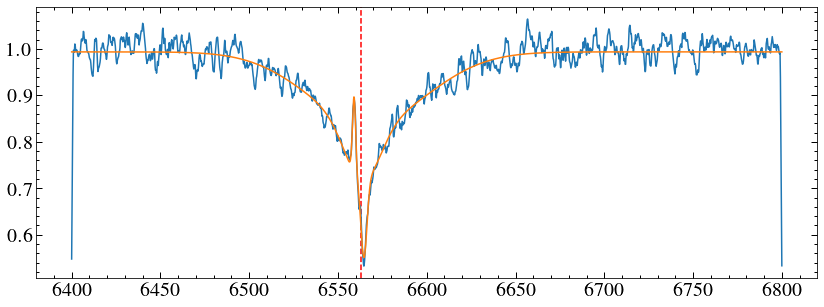

Model: CompoundModel2308
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
        amplitude_0            mean_0      ...      stddev_2        amplitude_3    
    -------------------- ----------------- ... ----------------- ------------------
    -0.16964592717321156 6564.108008445841 ... 35.38527868764185 0.9899740921022534


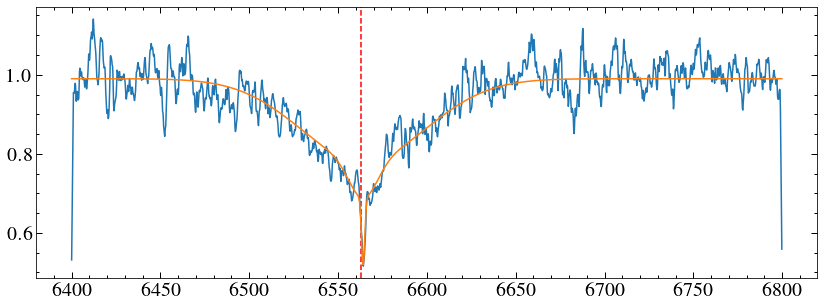

Model: CompoundModel2312
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6565.5155487, stddev=0.5)>
Parameters:
        amplitude_0           mean_0      ...       mean_4           stddev_4     
    -------------------- ---------------- ... ----------------- ------------------
    -0.11433911608369621 6563.10797885325 ... 6565.316902881372 0.9746387418325858


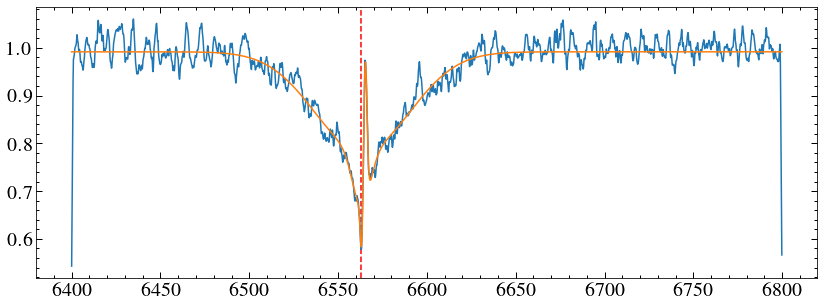

Model: CompoundModel2316
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6562.0888375, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...       mean_4           stddev_4     
    -------------------- ----------------- ... ----------------- ------------------
    -0.18227166711888057 6563.814968285623 ... 6561.784010079474 1.0153005630131307


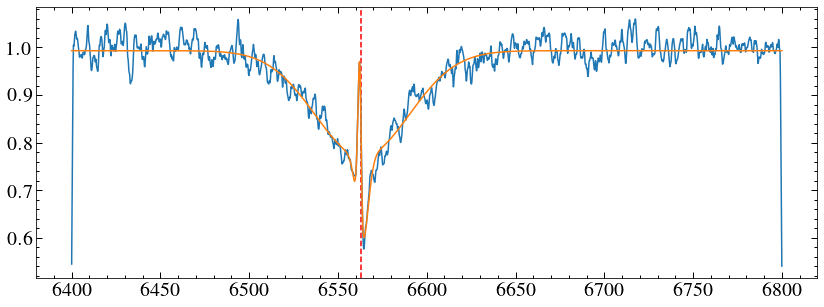

Model: CompoundModel2320
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6561.17463848, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...       mean_4           stddev_4     
    -------------------- ----------------- ... ----------------- ------------------
    -0.12661150305018518 6564.815354160727 ... 6561.020046374253 1.1650172317587857


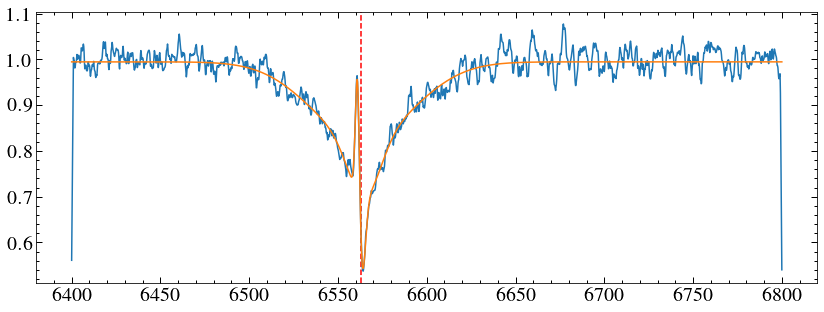

Model: CompoundModel2324
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6559.80372394, stddev=0.5)>
Parameters:
        amplitude_0           mean_0      ...       mean_4           stddev_4     
    ------------------- ----------------- ... ----------------- ------------------
    -0.2161270104559469 6564.376351463843 ... 6559.443497091464 0.8256873855054155


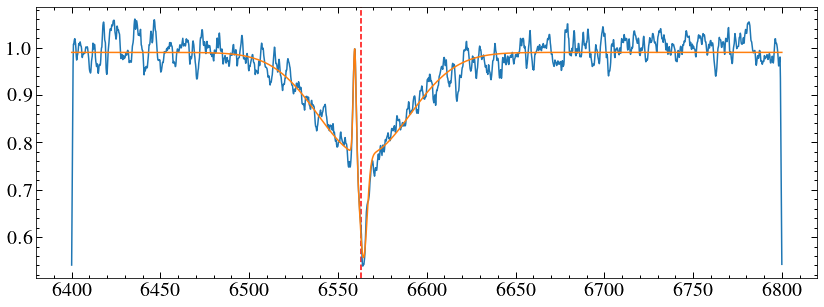

Model: CompoundModel2328
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6567.80118609, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...      mean_4          stddev_4    
    -------------------- ----------------- ... --------------- -----------------
    -0.15878620472611157 6563.196520407985 ... 6567.4871145053 0.926313591799788


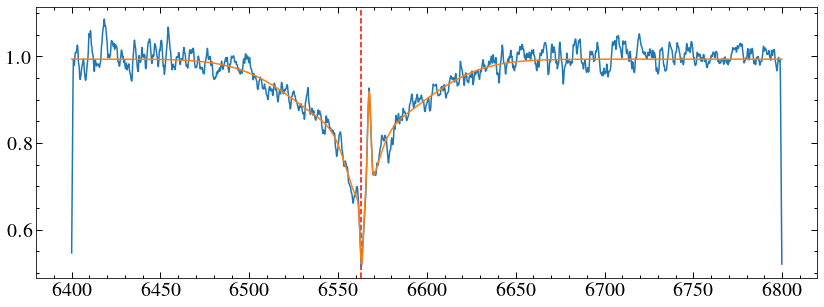

Model: CompoundModel2332
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6568.03001583, stddev=0.5)>
Parameters:
        amplitude_0           mean_0      ...       mean_4           stddev_4     
    ------------------- ----------------- ... ----------------- ------------------
    -0.1270345679292824 6563.725505127491 ... 6567.664491459063 1.2408799424567412


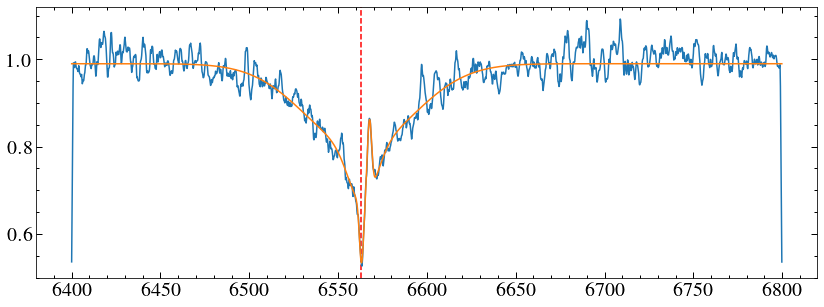

Model: CompoundModel2336
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6567.56258675, stddev=0.5)>
Parameters:
        amplitude_0           mean_0      ...       mean_4           stddev_4    
    ------------------- ----------------- ... ----------------- -----------------
    -2.7969743245992698 6566.993109680387 ... 6567.113634726842 6.450806896225983


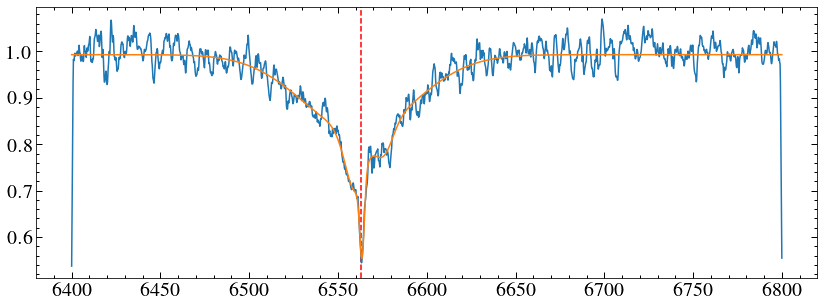

Model: CompoundModel2340
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6560.2584966, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...       mean_4           stddev_4    
    -------------------- ----------------- ... ----------------- -----------------
    -0.23428695908187627 6563.166793409001 ... 6558.872392375734 2.576334510790065


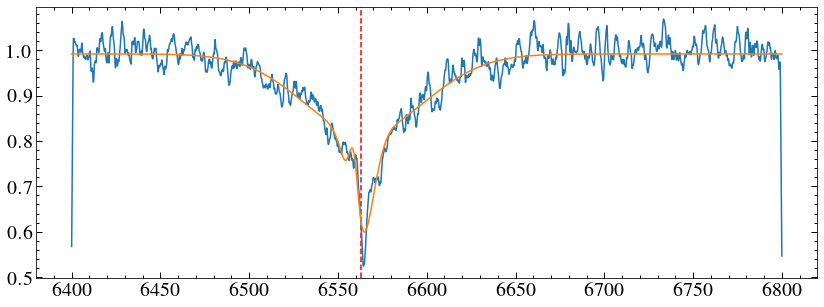

Model: CompoundModel2344
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=6559.5744818, stddev=0.5)>
Parameters:
        amplitude_0            mean_0      ...        stddev_4       
    -------------------- ----------------- ... ----------------------
    -0.07952217128061238 6570.879826944734 ... 1.1754943508222875e-38


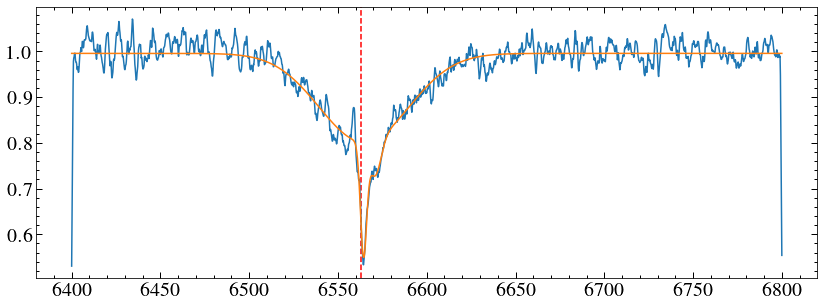

Model: CompoundModel2347
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Gaussian1D(amplitude=-0.3, mean=6562.77, stddev=1.)>

    [1]: <Gaussian1D(amplitude=-0.5, mean=6562.77, stddev=0.5)>

    [2]: <Gaussian1D(amplitude=-0.2, mean=6562.77, stddev=30.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
        amplitude_0           mean_0      ...      stddev_2        amplitude_3    
    -------------------- ---------------- ... ----------------- ------------------
    -0.11057926623002502 6564.10926368434 ... 32.75757518612315 0.9920591461407011


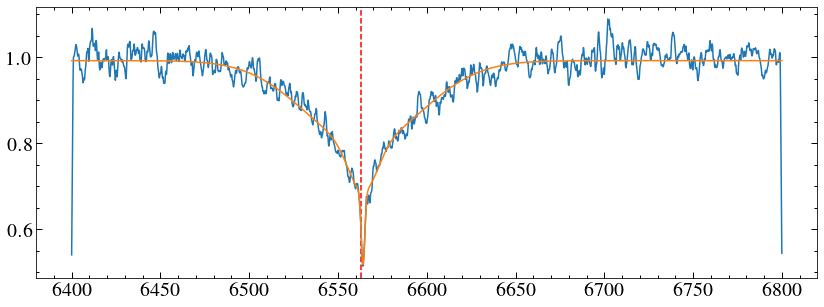

In [309]:
fitter = fitting.LevMarLSQFitter()
abs_dvs = []
abs_dves = []
abs_dates = []
halpha = 6562.77

def tiedfunc(gg_init):
    mean = gg_init.mean_0.value
    return mean

#sp_lines, xs = , line_list
for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
   # print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
    mask2 = (w> 6400) & (w < 6800) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    abs_dates.append(date)
    
    
    plt.figure() 
  
    plt.axvline(halpha, c='r', ls='--')
    gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.5, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0)
    gg_init.mean_1.tied=tiedfunc
    gg_init.mean_2.tied=tiedfunc
    if x != -1:
        rest_lam = lines[0]*u.AA
        obs_lam = x*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        h_guess = dv.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
        gg_init += models.Gaussian1D(1.0, h_guess,0.5)
        


    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=1000)
    #fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    print(gg_fit)
    #print(fit_e)
    
    plt.plot(w, f)
    plt.plot(w, gg_fit(w))
    plt.show()
    
    obs_line = gg_fit[1].mean*u.AA
    #obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    
    abs_dvs.append(dv)
    #abs_dves.append(dve)
    
    

<ErrorbarContainer object of 3 artists>

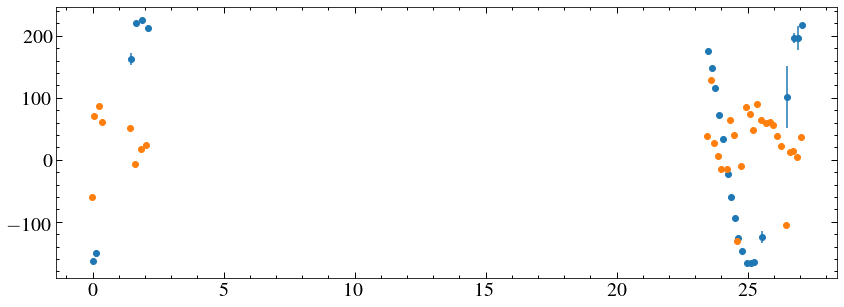

In [311]:
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')
t_abs = (abs_dates - min(abs(dates)))*24
plt.errorbar(t_abs, abs_dvs, ls='none', marker='o')

<ErrorbarContainer object of 3 artists>

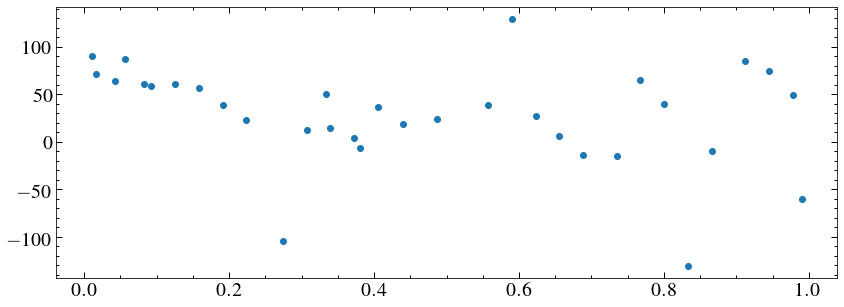

In [312]:
abs_fold = (t_abs/period) %1
plt.errorbar(abs_fold, abs_dvs, ls='none', marker='o')